In [1]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
### Create new output files with the hurricane at the center of the domain ####
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [2]:
#%% Define file locations
WRF_DIRECTORY_26 = "/projects/storm/mgomez/idealSims/sst_26_skipd01_skipCoLES_ndg/Results/" # precursor/
WRF_DIRECTORY_27 = "/projects/storm/mgomez/idealSims/sst_27real_skipd01_skipCoLES_ndg/Results/" # precursor/
# WRF_DIRECTORY_28 = "/projects/storm/mgomez/idealSims/sst_28_skipd01_skipCoLES_ndg/Results/" # precursor/
WRF_DIRECTORY_30 = "/projects/storm/mgomez/idealSims/sst_30_skipd01_skipCoLES_ndg/Results/" # precursor/
WRF_DIRECTORY_31 = "/scratch/mgomez/STORM/idealSims/sst_31_skipd01_skipCoLES_ndg/" # precursor/
WRF_DIRECTORY_32 = "/projects/storm/mgomez/idealSims/sst_32_skipd01_skipCoLES_ndg/Results/" # precursor/

dir_for_height = "/projects/storm/mgomez/idealSims/sst_32_skipd01_skipCoLES_ndg/"

WRF_DIRS = [WRF_DIRECTORY_26,WRF_DIRECTORY_27,WRF_DIRECTORY_30,WRF_DIRECTORY_31,WRF_DIRECTORY_32]

# Choose which domain to evaluate
domains = ['d01','d02']

# Whether or not to save figures
saveFig = 'False'

# Vertical level to get max wind speed
i_z_max = 0

dirFig = "/projects/storm/mgomez/idealSims/Figures/"

# Maximum height to save data
max_z_save = 1200 #500

In [3]:
# Choose one simulation and one domain
WRF_DIRECTORY = WRF_DIRS[0]
domain = domains[0]   
    
print(WRF_DIRECTORY)
print(domain)

/projects/storm/mgomez/idealSims/sst_26_skipd01_skipCoLES_ndg/Results/
d01


In [4]:
#%% Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4

In [5]:
# For figures
if 'sst_26' in WRF_DIRECTORY:
    lab_fig = 'sst_26'
elif 'sst_30' in WRF_DIRECTORY:
    lab_fig = 'sst_30'
elif 'sst_28' in WRF_DIRECTORY:
    lab_fig = 'sst_28'
elif 'sst_27real' in WRF_DIRECTORY:
    lab_fig = 'sst_27r'
elif 'sst_27' in WRF_DIRECTORY:
    lab_fig = 'sst_27'
elif 'sst_31' in WRF_DIRECTORY:
    lab_fig = 'sst_31'
elif 'sst_32' in WRF_DIRECTORY:
    lab_fig = 'sst_32'

In [6]:
# Extract height variables
if 'precursor' in WRF_DIRECTORY:
    WRF_DIRECTORY_tmp = WRF_DIRECTORY[0:-1*(len('precursor')+1)]
else:
    WRF_DIRECTORY_tmp = WRF_DIRECTORY
    
entries = os.listdir(dir_for_height)
ofInterest = []
for i in np.arange(len(entries)):
    if 'wrfrst' in entries[i]:
        ofInterest = np.append(ofInterest,i)
    if 'wrfout' in entries[i]:
        ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)
ds=xr.open_dataset(dir_for_height+str(entries[rndmFromInterest]),decode_times=False)
if 'wrfrst' in entries[rndmFromInterest]:
    ph = ds['PH_1']
else:
    ph = ds['PH']
ph = np.array(ph[0,:,:,:])
phb = ds['PHB']
phb = np.array(phb[0,:,:,:])
height_stag = (np.mean(ph,axis=(1,2))+np.mean(phb,axis=(1,2)))/9.81
height_agl = 0.5*(height_stag[1:] + height_stag[0:-1])
ds.close()
ph = 0.0
phb = 0.0

iz_max = np.argmin(np.abs(height_agl - max_z_save))


print(height_agl[0:10])


[ 10.788022  32.89681   56.097748  80.44559  105.99692  132.80931
 160.94324  190.46254  221.43457  253.92978 ]


In [7]:
#%% Define times for analysis
if 'precursor' in WRF_DIRECTORY:
    if 'sst_26' in WRF_DIRECTORY:
        time_0 = np.datetime64('2000-01-05T00:00:00')
        time_1 = time_0 + np.timedelta64(24,'h')
    elif 'sst_30' in WRF_DIRECTORY:
        time_0 = np.datetime64('2000-01-05T00:00:00')
        time_1 = time_0 + np.timedelta64(24,'h')
    elif 'sst_28' in WRF_DIRECTORY:
        time_0 = np.datetime64('2000-01-04T10:00:00')
        time_1 = time_0 + np.timedelta64(24,'h')
    elif 'sst_27real' in WRF_DIRECTORY:
        time_0 = np.datetime64('2000-01-06T00:00:00')
        time_1 = time_0 + np.timedelta64(24,'h')
    elif 'sst_27' in WRF_DIRECTORY:
        time_0 = np.datetime64('2000-01-05T00:00:00')
        time_1 = time_0 + np.timedelta64(24,'h')
else:
    if domain=='d01':
        # Choose times for analysis based on simulation
        if 'sst_26' in WRF_DIRECTORY:
            # time_0 = np.datetime64('2000-01-06T09:00:00')
            # time_1 = np.datetime64('2000-01-06T12:00:00')
            time_0 = np.datetime64('2000-01-06T10:00:00')
            time_1 = np.datetime64('2000-01-06T11:35:00')
        elif 'sst_27real' in WRF_DIRECTORY:
            # time_0 = np.datetime64('2000-01-06T14:00:00')
            # time_1 = np.datetime64('2000-01-06T17:00:00')
            time_0 = np.datetime64('2000-01-06T15:00:00')
            time_1 = np.datetime64('2000-01-06T16:35:00')
        elif 'sst_30' in WRF_DIRECTORY:
            # time_0 = np.datetime64('2000-01-06T09:00:00')
            # time_1 = np.datetime64('2000-01-06T12:00:00')
            time_0 = np.datetime64('2000-01-06T10:30:00')
            time_1 = np.datetime64('2000-01-06T11:35:00')
        # elif 'sst_28' in WRF_DIRECTORY:
        #     time_0 = np.datetime64('2000-01-06T09:00:00')
        #     time_1 = np.datetime64('2000-01-06T12:00:00')
        # elif 'sst_27' in WRF_DIRECTORY:
        #     time_0 = np.datetime64('2000-01-06T09:00:00')
        #     time_1 = np.datetime64('2000-01-06T12:00:00')
        elif 'sst_31' in WRF_DIRECTORY:
            time_0 = np.datetime64('2000-01-06T00:00:00')
            time_1 = np.datetime64('2000-01-06T04:00:00')
        elif 'sst_32' in WRF_DIRECTORY:
            # time_0 = np.datetime64('2000-01-05T07:00:00')
            # time_1 = np.datetime64('2000-01-05T10:00:00')
            time_0 = np.datetime64('2000-01-05T07:00:00')
            time_1 = np.datetime64('2000-01-05T08:35:00')
    elif domain=='d02':
        # Choose times for analysis based on simulation
        if 'sst_26' in WRF_DIRECTORY:
            time_0 = np.datetime64('2000-01-06T10:57:00')
            time_1 = np.datetime64('2000-01-06T11:30:00')
        elif 'sst_27real' in WRF_DIRECTORY:
            time_0 = np.datetime64('2000-01-06T16:00:00')
            time_1 = np.datetime64('2000-01-06T16:30:00')
        elif 'sst_28' in WRF_DIRECTORY:
            time_0 = np.datetime64('2000-01-06T10:56:00')
            time_1 = np.datetime64('2000-01-06T11:30:00')
        elif 'sst_30' in WRF_DIRECTORY:
            time_0 = np.datetime64('2000-01-06T11:00:00')
            time_1 = np.datetime64('2000-01-06T11:30:00')
        elif 'sst_32' in WRF_DIRECTORY:
            time_0 = np.datetime64('2000-01-05T08:00:00')
            time_1 = np.datetime64('2000-01-05T08:30:00')

# Find auxHist files for current domain within directory
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    # Check if domain matches
    if domain in entries[i]:
        # Check if it is an auxHist file
        if 'auxH' in entries[i]:
            # Check if time matches
            ds = xr.open_dataset(WRF_DIRECTORY+entries[i],decode_times=False)
            time_temp = np.array(ds['Times'])
            ds.close()
            ttime = np.array(['2000-01-01T00:00:00'], dtype='datetime64')
            a = str(time_temp)
            ttime = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
            if (ttime<time_1) & (ttime>time_0):
                ofInterest = np.append(ofInterest,i)
                print(entries[i])
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)


auxHist24_d01_2000-01-06_10:35:24
auxHist24_d01_2000-01-06_11:20:23
auxHist24_d01_2000-01-06_10:40:23
auxHist24_d01_2000-01-06_10:00:24
auxHist24_d01_2000-01-06_10:25:23
auxHist24_d01_2000-01-06_10:50:23
auxHist24_d01_2000-01-06_11:15:24
auxHist24_d01_2000-01-06_10:10:24
auxHist24_d01_2000-01-06_11:25:24
auxHist24_d01_2000-01-06_10:45:24
auxHist24_d01_2000-01-06_11:30:23
auxHist24_d01_2000-01-06_11:00:23
auxHist24_d01_2000-01-06_11:10:23
auxHist24_d01_2000-01-06_10:05:23
auxHist24_d01_2000-01-06_11:05:24
auxHist24_d01_2000-01-06_10:15:23
auxHist24_d01_2000-01-06_10:30:25
auxHist24_d01_2000-01-06_10:20:24
auxHist24_d01_2000-01-06_10:55:24


In [8]:
# Extract and save data from each auxHist file
for i_f in np.arange(0,len(ofInterest),1):
    # Open file
    ds = xr.open_dataset(WRF_DIRECTORY+str(entries[ofInterest[i_f]]),decode_times=False)
    # Extract data
    u_temp = np.array(ds['U'])
    v_temp = np.array(ds['V'])
    w_temp = np.array(ds['W'])
    time_temp = np.array(ds['Times'])
    # De-stagger variables
    u_temp = 0.5*(u_temp[:,:,:,0:np.shape(u_temp)[3]-1]+u_temp[:,:,:,1:np.shape(u_temp)[3]])
    v_temp = 0.5*(v_temp[:,:,0:np.shape(v_temp)[2]-1,:]+v_temp[:,:,1:np.shape(v_temp)[2],:])
    w_temp = 0.5*(w_temp[:,0:np.shape(w_temp)[1]-1,:,:]+w_temp[:,1:np.shape(w_temp)[1],:,:])
    # Save variables
    if i_f==0:
        # Only keep data within heights of interest
        u_temp = u_temp[:,0:iz_max,:,:]
        v_temp = v_temp[:,0:iz_max,:,:]
        w_temp = w_temp[:,0:iz_max,:,:]
        height_agl = height_agl[0:iz_max]
        # Create new variables
        u = np.zeros_like(u_temp) + u_temp
        v = np.zeros_like(v_temp) + v_temp
        w = np.zeros_like(w_temp) + w_temp
        Time = []
        Time.append(time_temp)
        # Domain dimensions
        dx = ds.DX
        n_x = dx*np.arange(0,np.shape(u)[3])
        n_y = dx*np.arange(0,np.shape(u)[2])
        # Free-up memory
        ph = 0.0
        phb = 0.0
        height_stag = 0.0
    else:
        # Only keep data within heights of interest
        u_temp = u_temp[:,0:iz_max,:,:]
        v_temp = v_temp[:,0:iz_max,:,:]
        w_temp = w_temp[:,0:iz_max,:,:]
        # Append data to saved variables
        u = np.append(u,u_temp,axis=0)
        v = np.append(v,v_temp,axis=0)
        w = np.append(w,w_temp,axis=0)
        Time.append(time_temp)
    # Free-up memory
    u_temp = 0.0
    v_temp = 0.0
    w_temp = 0.0
    uv_temp = 0.0
    # Close file
    ds.close()
    print('Done with %i out of %i' % (i_f+1,len(ofInterest)))
    
uv = (u**2 + v**2)**0.5

Done with 1 out of 19
Done with 2 out of 19
Done with 3 out of 19
Done with 4 out of 19
Done with 5 out of 19
Done with 6 out of 19
Done with 7 out of 19
Done with 8 out of 19
Done with 9 out of 19
Done with 10 out of 19
Done with 11 out of 19
Done with 12 out of 19
Done with 13 out of 19
Done with 14 out of 19
Done with 15 out of 19
Done with 16 out of 19
Done with 17 out of 19
Done with 18 out of 19
Done with 19 out of 19


In [9]:
#%% Create time vector (after initialization) (ignore dates)
# Create large datetime64 array
ttime = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time)[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time)[0]):
    a = str(Time[i_t])
    ttime[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime = ttime[0:np.shape(Time)[0]]

In [10]:
#%% Sort 3D fields by time
i_sort = np.argsort(ttime)
ttime = ttime[i_sort]
u = u[i_sort,:,:,:]
v = v[i_sort,:,:,:]
w = w[i_sort,:,:,:]
uv = uv[i_sort,:,:,:]

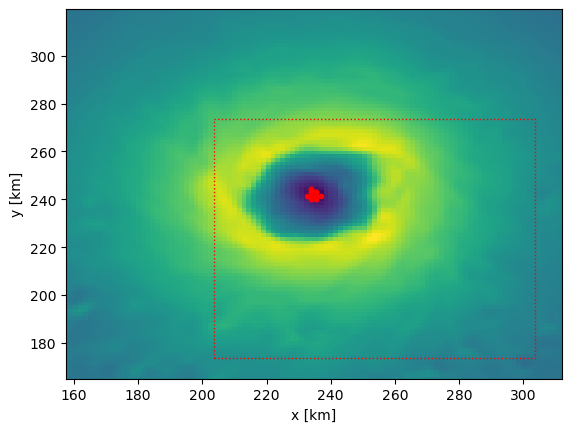

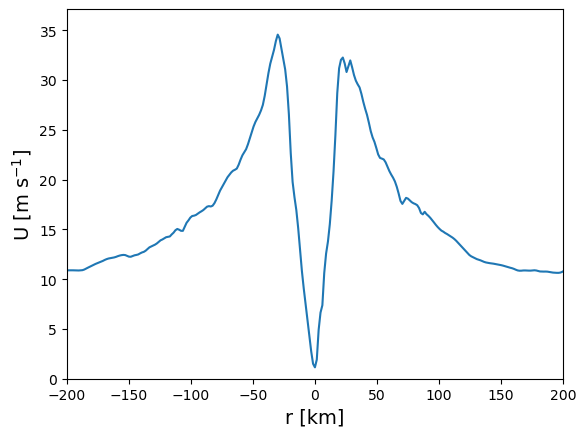

In [11]:
#%% Find hurricane center for each time
# Choose height at which the center of the hurricane is going to be defined
iz_c = 0

# Initialize array
center = np.zeros([len(ttime),2]) + np.nan # [x,y]

X_grid,Y_grid = np.meshgrid(n_x,n_y)
X_grid = X_grid.flatten()
Y_grid = Y_grid.flatten()

for iitt in np.arange(np.shape(uv)[0]):
    # Ignore boundaries of domain
    temp_uv = np.zeros(np.shape(uv[iitt,iz_c,:,:])) + uv[iitt,iz_c,:,:]
    temp_uv[0:10,:] = np.nan
    temp_uv[-10:,:] = np.nan
    temp_uv[:,0:10] = np.nan
    temp_uv[:,-10:] = np.nan
    uv_flat = temp_uv.flatten() 
    uv_flat[np.isnan(uv_flat)] = 0
    max_ws_ref = np.argmax(uv_flat)
    temp_x,temp_y = np.meshgrid(n_x,n_y)
    temp_x = temp_x.flatten()
    temp_y = temp_y.flatten()
    # Limits of area where to look for hurricane center
    lim_low_x = temp_x[np.argmax(uv_flat)] - 50000
    lim_low_y = temp_y[np.argmax(uv_flat)] - 50000
    lim_high_x = temp_x[np.argmax(uv_flat)] + 50000
    lim_high_y = temp_y[np.argmax(uv_flat)] + 50000
    
    if domain=='d02':
        lim_low_x = np.mean(n_x) - 0.3*n_x[-1]
        lim_low_y = np.mean(n_x) - 0.3*n_x[-1]
        lim_high_x = np.mean(n_x) + 0.3*n_x[-1]
        lim_high_y = np.mean(n_x) + 0.3*n_x[-1]
    temp_x = 0.0
    temp_y = 0.0
    # Create small meshgrid
    small_x,small_y = np.meshgrid(n_x[(n_x<lim_high_x)&(n_x>lim_low_x)],n_y[(n_y<lim_high_y)&(n_y>lim_low_y)])
    flat_smallX = small_x.flatten()
    flat_smallY = small_y.flatten()

    # Crop array
    temp_uv_1 = uv[iitt,0,(n_y<lim_high_y)&(n_y>lim_low_y),:]
    temp_uv_2 = temp_uv_1[:,(n_x<lim_high_x)&(n_x>lim_low_x)]
    # Flatten array
    temp_uv_flat = temp_uv_2.flatten()
    # Find location of minimum
    if np.any(temp_uv_flat)==True:
        i_min = np.argmin(temp_uv_flat)
        # Save location of minimum
        center[iitt,0] = flat_smallX[i_min]
        center[iitt,1] = flat_smallY[i_min]
    else:
        # Save location of minimum
        center[iitt,0] = np.mean(n_x)
        center[iitt,1] = np.mean(n_y)
# Free-up memory
X_grid = 0.0
Y_grid = 0.0
temp_uv = 0.0
uv_flat = 0.0
max_ws_ref = 0.0
small_x = 0.0
small_y = 0.0
flat_smallX = 0.0
flat_smallY = 0.0
temp_uv_1 = 0.0
temp_uv_2 = 0.0
temp_uv_flat = 0.0

# Visualize results for a given time
iitt = -1

# Show area considered for center of hurricane
plt.figure()
plt.pcolormesh(n_x/1000,n_y/1000,uv[iitt,iz_c,:,:]) 
plt.plot(center[:,0]/1000,center[:,1]/1000,'o-',color='red',markersize=3)
# plt.scatter(center[iitt,0]/1000,center[iitt,1]/1000)
plt.fill(np.array([lim_low_x,lim_high_x,lim_high_x,lim_low_x])/1000,np.array([lim_low_y,lim_low_y,lim_high_y,lim_high_y])/1000,facecolor='none',edgecolor='r',linestyle=':',label='Area')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlim((min(center[:,0]) - 50*dx)/1000,(max(center[:,0]) + 50*dx)/1000)
plt.ylim((min(center[:,1]) - 50*dx)/1000,(max(center[:,1]) + 50*dx)/1000)
plt.show()
plt.close()  


# Radial distribution of wind speed
plt.figure()
r_x = (n_x - center[iitt,0])/1000
plt.plot(r_x,uv[iitt,0,int(center[iitt,1]/dx),:])
plt.xlim(np.min((n_x - center[iitt,0])/1000),np.max((n_x - center[iitt,0])/1000))
plt.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
plt.ylim(0,np.max(uv[:,iz_c,int(center[iitt,1]/dx),:]))
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()  



In [12]:
#%% Find geometrical center for LES (it is nearly unchanged for mesoscale)
if domain == 'd02':
    # Choose height at which the center of the hurricane is going to be defined
    iz_c = 0

    # Initialize array
    center_geo = np.zeros_like(center) + np.nan # [x,y]

    X_grid,Y_grid = np.meshgrid(n_x,n_y)
    X_grid = X_grid.flatten()
    Y_grid = Y_grid.flatten()

    for iitt in np.arange(np.shape(uv)[0]):
        # Find center of hurricane as mid-point between maxima
        for i_n in np.arange(20):
            if i_n==0:
                temp_cent = center[iitt,:] + 0.0
            else:
                temp_cent = center_geo[iitt,:] + 0.0
            temp_uv = np.zeros(np.shape(uv[iitt,iz_c,:,:])) + uv[iitt,iz_c,:,:]

            cent0_y = np.argmax(temp_uv[0:int(temp_cent[1]/dx),int(temp_cent[0]/dx)])
            cent1_y = int(temp_cent[1]/dx) + np.argmax(temp_uv[int(temp_cent[1]/dx):,int(temp_cent[0]/dx)])

            cent0_x = np.argmax(temp_uv[int(temp_cent[1]/dx),0:int(temp_cent[0]/dx)])
            cent1_x = int(temp_cent[0]/dx) + np.argmax(temp_uv[int(temp_cent[1]/dx),int(temp_cent[0]/dx):])

            center_geo[iitt,0] = dx*np.mean([cent0_x,cent1_x])
            center_geo[iitt,1] = dx*np.mean([cent0_y,cent1_y])
        
    print(center_geo/dx)
    print(center/dx)
    
    # Visualize results for a given time
    iitt = -1

    # Show area considered for center of hurricane
    plt.figure()
    plt.pcolormesh(n_x/1000,n_y/1000,uv[iitt,iz_c,:,:]) 
    plt.plot(center[:,0]/1000,center[:,1]/1000,'o-',color='red',markersize=3)
    plt.plot(center_geo[:,0]/1000,center_geo[:,1]/1000,'o-',color='orange',markersize=3)
    # plt.scatter(center[iitt,0]/1000,center[iitt,1]/1000)
    plt.fill(np.array([lim_low_x,lim_high_x,lim_high_x,lim_low_x])/1000,np.array([lim_low_y,lim_low_y,lim_high_y,lim_high_y])/1000,facecolor='none',edgecolor='r',linestyle=':',label='Area')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
#     plt.xlim((min(center[:,0]) - 80*dx)/1000,(max(center[:,0]) + 80*dx)/1000)
#     plt.ylim((min(center[:,1]) - 80*dx)/1000,(max(center[:,1]) + 80*dx)/1000)
    plt.show()
    plt.close()  


    # Radial distribution of wind speed
    plt.figure()
    r_x = (n_x - center_geo[iitt,0])/1000
    plt.plot(r_x,uv[iitt,0,int(center_geo[iitt,1]/dx),:])
    plt.xlim(np.min((n_x - center_geo[iitt,0])/1000),np.max((n_x - center_geo[iitt,0])/1000))
    plt.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
    plt.ylim(0,np.max(uv[:,iz_c,int(center_geo[iitt,1]/dx),:]))
    plt.xlabel('r [km]',fontsize=14)
    plt.ylabel('U [m s$^{-1}$]',fontsize=14)
    plt.show()
    plt.close()  
    
    # Use geometrical center instead of wind speed minima
    center = np.zeros_like(center_geo) + center_geo

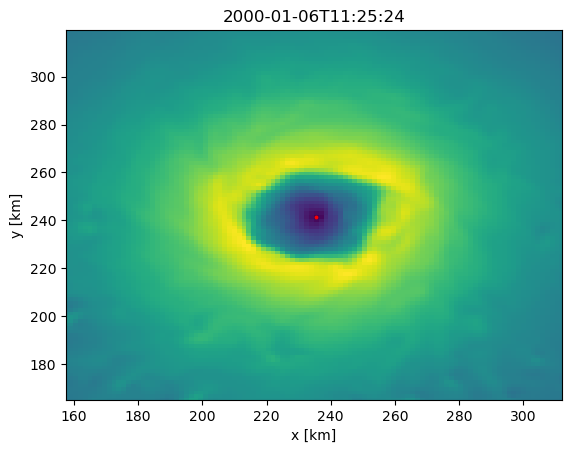

17
19


In [13]:
# Visualize results for a given time
# stop
if domain == 'd01':
    iitt = len(ttime)-2 # 21

    # Show area considered for center of hurricane
    plt.figure()
    plt.title(str(ttime[iitt]))
    plt.pcolormesh(n_x/1000,n_y/1000,uv[iitt,iz_c,:,:]) 
    plt.scatter(center[iitt,0]/1000,center[iitt,1]/1000,color='red',s=3)
    # plt.plot(center[:,0]/1000,center[:,1]/1000,'o-',color='red',markersize=3)
    # plt.fill(np.array([lim_low_x,lim_high_x,lim_high_x,lim_low_x])/1000,np.array([lim_low_y,lim_low_y,lim_high_y,lim_high_y])/1000,facecolor='none',edgecolor='r',linestyle=':',label='Area')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    plt.xlim((min(center[:,0]) - 50*dx)/1000,(max(center[:,0]) + 50*dx)/1000)
    plt.ylim((min(center[:,1]) - 50*dx)/1000,(max(center[:,1]) + 50*dx)/1000)
    plt.show()
    plt.close()  
    
    print(iitt)
    print(len(ttime))


In [14]:
#%% Crop all 3D fields to a shared reference frame that is centered on the center of the hurricane
# Find the maximum radial distance from the hurricane's center that is shared for all times
max_dist_fromCent = 100000
for it in np.arange(len(ttime)):
    # Distance from hurricane cetner to domain boundaries
    dd_x = np.min([center[it,0] - n_x[0],n_x[-1] - center[it,0]])
    dd_y = np.min([center[it,1] - n_y[0],n_y[-1] - center[it,1]])
    # Minimum distance to domain boundaries
    dd = np.min([dd_x,dd_y])
    if dd<max_dist_fromCent:
        max_dist_fromCent = dd
# Round down
temp = np.floor(max_dist_fromCent/1000)
max_dist_fromCent = temp*1000

# Initialize array
u_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
v_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
w_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
uv_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan

for iitt in np.arange(len(ttime)):
    # Geometrical center
    geo_cent = [center[iitt,0],center[iitt,1]]
    ix_c = int(geo_cent[0]/dx)
    iy_c = int(geo_cent[1]/dx)
    # Save portion of hurricane
    if iitt==0:
        dim1 = np.shape(u_r[iitt,:,:,:])[-1]
        dim2 = np.shape(u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)])[-1]
    if dim1==dim2:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
    else:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    
    
# Release memory
if domain == 'd01':
    print('do nothing')
else:
    u = 0.0
    v = 0.0
    w = 0.0
    uv = 0.0

# Temporal average of centered velocity fields
mean_u_r = np.nanmean(u_r,axis=0)
mean_v_r = np.nanmean(v_r,axis=0)
mean_w_r = np.nanmean(w_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)

# New distance arrays
n_x_r = np.arange(np.shape(mean_uv_r)[2])*dx
n_x_r = n_x_r - n_x_r[int(0.5*len(n_x_r))]
n_y_r = np.arange(np.shape(mean_uv_r)[1])*dx
n_y_r = n_y_r - n_y_r[int(0.5*len(n_y_r))]
# temp_gridx,temp_gridy = np.meshgrid(n_x_r,n_y_r)
# temp_uv = mean_uv_r[0,:,:].flatten()
# temp_gridx = temp_gridx.flatten()
# temp_gridy = temp_gridy.flatten()
# n_x_r = n_x_r - temp_gridx[np.argmin(temp_uv)]
# n_y_r = n_y_r - temp_gridy[np.argmin(temp_uv)]

# stop

temp_uv = 0.0
temp_gridx = 0.0
temp_gridy = 0.0

do nothing


In [15]:
np.shape(uv_r[iitt,:,:,:])

(28, 133, 133)

In [16]:
#%% Crop 3D fields to make them centered in a rectangle (x-y)
min_x = np.min(np.abs(np.array([n_x_r[0],n_x_r[-1]])))
min_y = np.min(np.abs(np.array([n_y_r[0],n_y_r[-1]])))

u_r = u_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
u_r = u_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

v_r = v_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
v_r = v_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

w_r = w_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
w_r = w_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

uv_r = uv_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
uv_r = uv_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

n_x_r = n_x_r[(n_x_r>-1*min_x)&(n_x_r<min_x)]
n_y_r = n_y_r[(n_y_r>-1*min_y)&(n_y_r<min_y)]

# Temporal average of centered velocity fields
mean_u_r = np.nanmean(u_r,axis=0)
mean_v_r = np.nanmean(v_r,axis=0)
mean_w_r = np.nanmean(w_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)


In [17]:
# stop

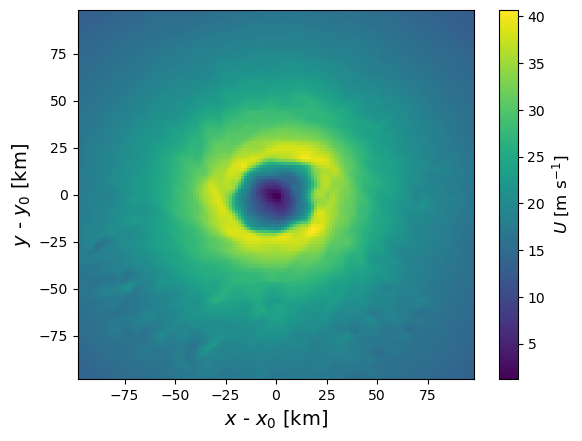

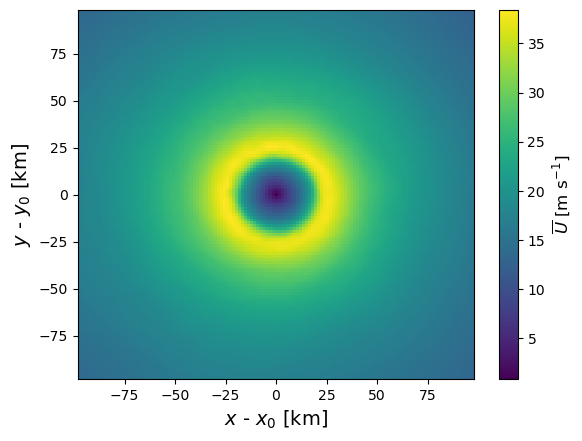

19
d01
/projects/storm/mgomez/idealSims/sst_26_skipd01_skipCoLES_ndg/Results/
18


In [18]:
# Velocity contours at one height
iz = 1
it = len(ttime)-1

# Instantaneous
plt.figure()
# plt.title(ttime[it])
tmp = uv_r[it,iz,:,:] + 0.0
# for iy in np.arange(len(n_y_r)-50,len(n_y_r)):
#     tmp[iy,:] = np.mean(np.flip(tmp[0:10,:]),axis=0)
# for iy in np.arange(len(n_y_r)-90,len(n_y_r)-50):
#     ii = len(n_y_r) - iy
#     tmp[iy,:] = np.flip(tmp[int(ii/2),:])
# tmp[-80:,:] = np.flip(tmp[0:80,:])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,tmp)
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
# plt.ylim(n_y_r[0]/1000,33)
cbar = plt.colorbar(im1)
cbar.set_label(r'$U$ [m s$^{-1}$]',fontsize=12)
plt.savefig(dirFig + "inst_U_" + lab_fig + ".png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
plt.show()
plt.close()  

# Time-averaged
plt.figure()
# plt.title(ttime[it])
tmp = np.nanmean(uv_r[:,iz,:,:],axis=0)
# for iy in np.arange(len(n_y_r)-50,len(n_y_r)):
#     tmp[iy,:] = np.mean(np.flip(tmp[0:10,:]),axis=0)
# for iy in np.arange(len(n_y_r)-90,len(n_y_r)-50):
#     ii = len(n_y_r) - iy
#     tmp[iy,:] = np.flip(tmp[int(ii/2),:])
# tmp[-80:,:] = np.flip(tmp[0:80,:])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,tmp)
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
# plt.ylim(n_y_r[0]/1000,33)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ [m s$^{-1}$]',fontsize=12)
plt.savefig(dirFig + "time_avg_U_" + lab_fig + ".png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
plt.show()
plt.close()  

tmp = 0.0

print(len(ttime))
print(domain)
print(WRF_DIRECTORY)
print(it)

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_678125/3575507759.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\overline{U}$  [m s$^{-1}$]',fontsize=14)


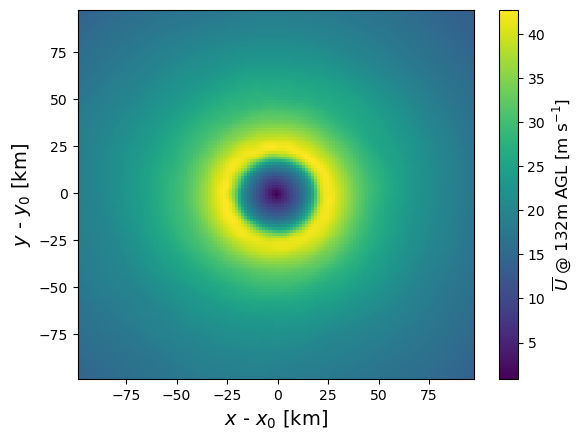

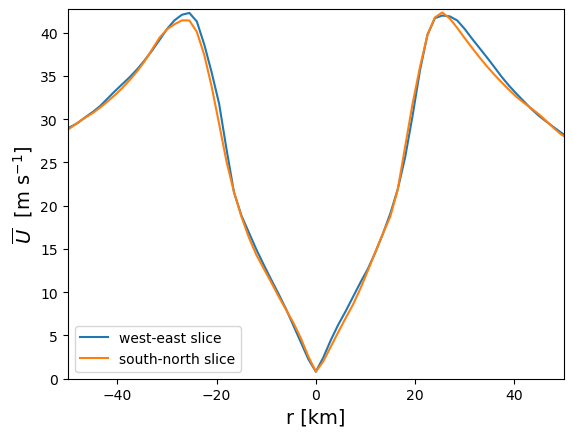

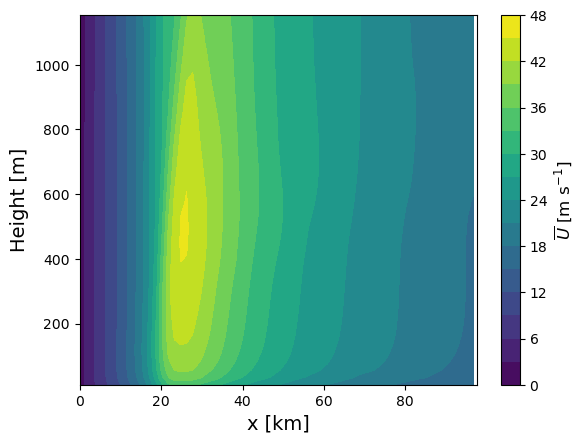

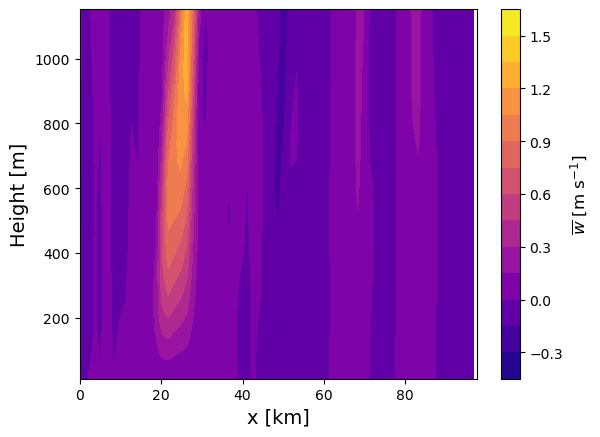

33.97209187557823
34.191829882170026


In [19]:
#%% Figures showing time-averaged velocity fields for centered hurricane

# Velocity contours at one height
iz = 5
plt.figure()
# im1 = plt.contourf((n_x_r-0.5*dx)/1000,(n_y_r-0.5*dx)/1000,mean_uv_r[iz,:,:],levels=15) 
im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,(n_y_r-0.5*dx)/1000,mean_uv_r[iz,:,:])
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
# plt.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
plt.show()
plt.close()  

# Radial distribution of winds at one height
plt.figure()
plt.plot(n_x_r/1000,mean_uv_r[iz,int(0.5*len(n_y_r)),:],label='west-east slice')
plt.plot(n_y_r/1000,mean_uv_r[iz,:,int(0.5*len(n_x_r))],label='south-north slice')
plt.xlim(-50,50)
plt.ylim(0,np.max(mean_uv_r[iz,:,:]))
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('$\overline{U}$  [m s$^{-1}$]',fontsize=14)
plt.legend()
# plt.savefig(WRF_DIRECTORY + "r_hurr.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
plt.show()
plt.close()  

# Slice of velocity field
plt.figure()
im1 = plt.contourf((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:],levels=15) 
# im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:])
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ [m s$^{-1}$]',fontsize=12)
# plt.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
plt.show()
plt.close()  

# Slice of vertical velocity field
plt.figure()
im1 = plt.contourf((n_x_r-0.5*dx)/1000,height_agl,mean_w_r[:,int(0.5*len(n_y_r)),:],levels=15,cmap=plt.cm.plasma) 
# im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:])
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{w}$ [m s$^{-1}$]',fontsize=12)
# plt.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
plt.show()
plt.close()  


print(np.max(mean_uv_r[0,int(0.5*len(n_y_r)),int(0.5*len(n_x_r)):]))
print(np.max(mean_uv_r[0,int(0.5*len(n_y_r)),0:int(0.5*len(n_x_r))]))

In [20]:
#%% Create netcdf file to save data
u_r = xr.DataArray(data=u_r, 
                     dims=("t","z","y","x"), 
                     coords={"t":ttime,"z":height_agl,"y":n_y_r,"x":n_x_r}, 
                     name="u_r",
                     attrs={"long_name":"zonal wind component","units":"m/s"})
v_r = xr.DataArray(data=v_r, 
                     dims=("t","z","y","x"), 
                     coords={"t":ttime,"z":height_agl,"y":n_y_r,"x":n_x_r}, 
                     name="v_r",
                     attrs={"long_name":"meridional wind component","units":"m/s"})
w_r = xr.DataArray(data=w_r, 
                     dims=("t","z","y","x"), 
                     coords={"t":ttime,"z":height_agl,"y":n_y_r,"x":n_x_r}, 
                     name="w_r",
                     attrs={"long_name":"vertical wind component","units":"m/s"})
uv_r = xr.DataArray(data=uv_r, 
                     dims=("t","z","y","x"), 
                     coords={"t":ttime,"z":height_agl,"y":n_y_r,"x":n_x_r}, 
                     name="uv_r",
                     attrs={"long_name":"horizontal wind component","units":"m/s"})
dataset = xr.Dataset(data_vars={"u_r":u_r,"v_r":v_r,"w_r":w_r,"uv_r":uv_r})

print(dataset)
    
if 'precursor' in WRF_DIRECTORY:
    netcdf_f_name = WRF_DIRECTORY_tmp + "cropped/"
    if not os.path.exists(netcdf_f_name):
        os.makedirs(netcdf_f_name)
    netcdf_f_name = netcdf_f_name + "cropped_"+domain+"_prec.nc"
else:
    netcdf_f_name = WRF_DIRECTORY + "cropped/"
    if not os.path.exists(netcdf_f_name):
        os.makedirs(netcdf_f_name)
    netcdf_f_name = netcdf_f_name + "cropped_"+domain+".nc"

print(netcdf_f_name)

dataset.to_netcdf(path=netcdf_f_name,mode='w')
dataset.close()



<xarray.Dataset>
Dimensions:  (t: 19, z: 28, y: 131, x: 131)
Coordinates:
  * t        (t) datetime64[ns] 2000-01-06T10:00:24 ... 2000-01-06T11:30:23
  * z        (z) float32 10.79 32.9 56.1 80.45 ... 1.033e+03 1.094e+03 1.154e+03
  * y        (y) float64 -9.75e+04 -9.6e+04 -9.45e+04 ... 9.6e+04 9.75e+04
  * x        (x) float64 -9.75e+04 -9.6e+04 -9.45e+04 ... 9.6e+04 9.75e+04
Data variables:
    u_r      (t, z, y, x) float64 9.955 10.06 10.19 ... -9.913 -9.825 -9.77
    v_r      (t, z, y, x) float64 -7.746 -7.761 -7.744 ... 10.05 9.971 9.848
    w_r      (t, z, y, x) float64 0.0007125 0.0004136 ... 0.0724 0.06719
    uv_r     (t, z, y, x) float64 12.61 12.71 12.8 12.88 ... 14.12 14.0 13.87
/projects/storm/mgomez/idealSims/sst_26_skipd01_skipCoLES_ndg/Results/cropped/cropped_d01.nc


/tmp/ipykernel_678125/256576382.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  u_r = xr.DataArray(data=u_r,
/tmp/ipykernel_678125/256576382.py:7: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision 

In [21]:
# stop

## Azimuthally and temporally averaged atmospheric variables

In [22]:
#%% Time-averaged velocity fields

#%% Time-averaged velocity fields
mean_u_r = 0.0
mean_v_r = 0.0
mean_w_r = 0.0
mean_uv_r = 0.0

tAvg_u_r = np.mean(np.array(u_r),axis=0)
tAvg_v_r = np.mean(np.array(v_r),axis=0)
tAvg_w_r = np.mean(np.array(w_r),axis=0)
tAvg_uv_r = np.mean(np.array(uv_r),axis=0)


In [23]:
#%% Filter time-averaged vertical velocity from LES domains
from scipy.ndimage import gaussian_filter
filt_w = False
if domain=='d02':
    if filt_w:
        nonFilt_w = np.zeros_like(tAvg_w_r) + tAvg_w_r
        
        sigma_ = 5
        for iz in np.arange(len(height_agl)):
            tAvg_w_r[iz,:,:] = gaussian_filter(tAvg_w_r[iz,:,:], sigma=sigma_)


In [24]:
#%% Tangential and normal velocity components

# Project velocity components from Cartesian reference frame to normal and tangential reference frame

U_t = np.zeros_like(tAvg_u_r)
U_n = np.zeros_like(tAvg_u_r)
for ix in np.arange(len(n_x_r)):
    for iy in np.arange(len(n_y_r)):
        theta = np.arctan2(n_y_r[iy],n_x_r[ix])
        # t = -i sin(theta) + j cos(theta)
        U_t[:,iy,ix] = -1*tAvg_u_r[:,iy,ix]*np.sin(theta) + tAvg_v_r[:,iy,ix]*np.cos(theta)
        # n = - i cos(theta) -j sin(theta) 
        U_n[:,iy,ix] = -1*tAvg_u_r[:,iy,ix]*np.cos(theta) - tAvg_v_r[:,iy,ix]*np.sin(theta)
        
# Change from normal velocity to radial velocity
U_n = -1*U_n

# # Instantaneous radial and tangential velocity components
# U_t_i = np.zeros_like(np.array(u_r))
# U_n_i = np.zeros_like(np.array(u_r))
# for it in np.arange(len(ttime)):
#     for ix in np.arange(len(n_x_r)):
#         for iy in np.arange(len(n_y_r)):
#             theta = np.arctan2(n_y_r[iy],n_x_r[ix])
#             # t = -i sin(theta) + j cos(theta)
#             U_t_i[it,:,iy,ix] = -1*np.array(u_r[it,:,iy,ix])*np.sin(theta) + np.array(v_r[it,:,iy,ix])*np.cos(theta)
#             # n = - i cos(theta) -j sin(theta) 
#             U_n_i[it,:,iy,ix] = -1*np.array(u_r[it,:,iy,ix])*np.cos(theta) - np.array(v_r[it,:,iy,ix])*np.sin(theta)
        
# # Change from normal velocity to radial velocity
# U_n_i = -1*U_n_i


In [25]:
# # Instantaneous radial and tangential velocity components
# U_t_i = np.zeros_like(np.array(u_r))
# U_n_i = np.zeros_like(np.array(u_r))
# for ix in np.arange(len(n_x_r)):
#     for iy in np.arange(len(n_y_r)):
#         theta = np.arctan2(n_y_r[iy],n_x_r[ix])
#         # t = -i sin(theta) + j cos(theta)
#         U_t_i[:,:,iy,ix] = -1*np.array(u_r[:,:,iy,ix])*np.sin(theta) + np.array(v_r[:,:,iy,ix])*np.cos(theta)
#         # n = - i cos(theta) -j sin(theta) 
#         U_n_i[:,:,iy,ix] = -1*np.array(u_r[:,:,iy,ix])*np.cos(theta) - np.array(v_r[:,:,iy,ix])*np.sin(theta)
        
# # Change from normal velocity to radial velocity
# U_n_i = -1*U_n_i


/tmp/ipykernel_678125/3067483533.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  azmth_w_r[ia,iz,ir] = ww[0,:]


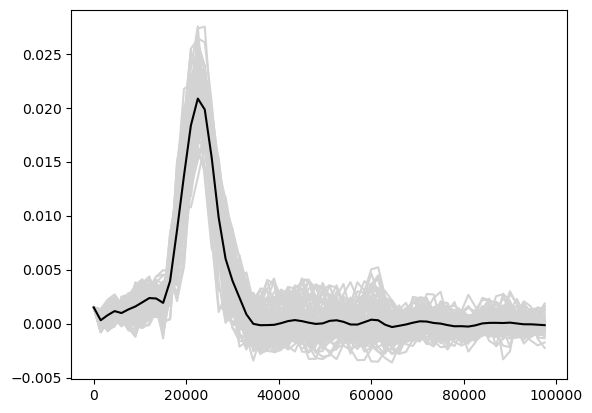

/tmp/ipykernel_678125/3067483533.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  azmth_UV_r[ia,iz,ir] = ww[0,:]


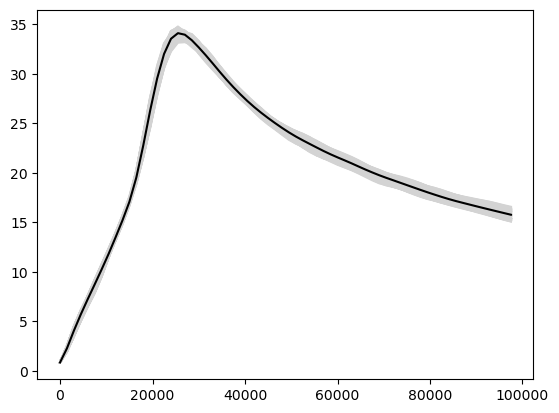

/tmp/ipykernel_678125/3067483533.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  azmth_Ut_r[ia,iz,ir] = ww[0,:]


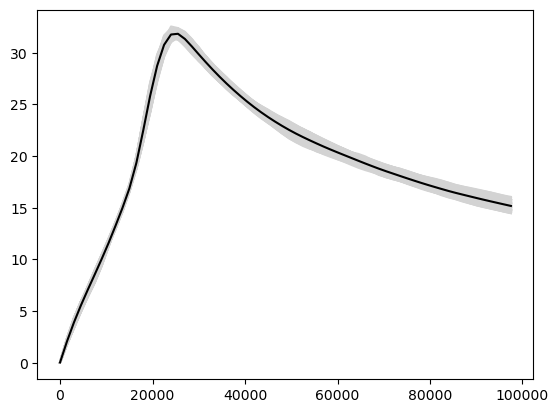

/tmp/ipykernel_678125/3067483533.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  azmth_Un_r[ia,iz,ir] = ww[0,:]


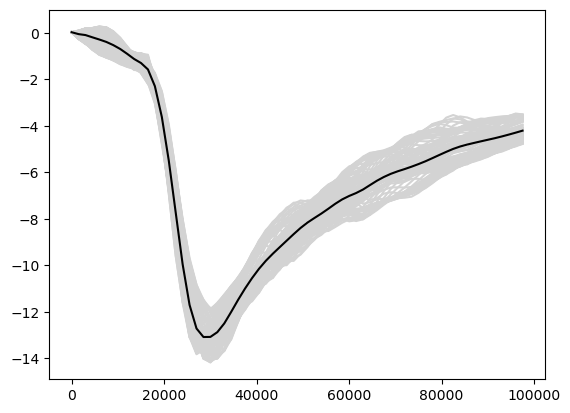

In [26]:
#%% Azimuthally and temporally averaged velocity fields (LES only)
azmth = np.linspace(1,359,100)

## Radial vector
rr_ = n_x_r[n_x_r>=0]

# Vertical velocity
azmth_w_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,tAvg_w_r[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_w_r[ia,iz,ir] = ww[0,:]
plt.figure()
for ia in np.arange(len(azmth)):
    plt.plot(rr_,azmth_w_r[ia,0,:],color='lightgrey')
if (domain == 'd04') | (domain == 'd05'):
    plt.plot(n_x_r,nonFilt_w[iz,int(0.5*len(n_y_r)),:],color='lightgrey')
plt.plot(rr_,np.mean(azmth_w_r[:,0,:],axis=0),'-k')
plt.show()
plt.close()

# Horizontal velocity
azmth_UV_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,tAvg_uv_r[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_UV_r[ia,iz,ir] = ww[0,:]
plt.figure()
for ia in np.arange(len(azmth)):
    plt.plot(rr_,azmth_UV_r[ia,0,:],color='lightgrey')
plt.plot(rr_,np.mean(azmth_UV_r[:,0,:],axis=0),'-k')
plt.show()
plt.close()

# Tangential velocity
azmth_Ut_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_t[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_Ut_r[ia,iz,ir] = ww[0,:]
plt.figure()
for ia in np.arange(len(azmth)):
    plt.plot(rr_,azmth_Ut_r[ia,0,:],color='lightgrey')
plt.plot(rr_,np.mean(azmth_Ut_r[:,0,:],axis=0),'-k')
plt.show()
plt.close()

# Radial velocity
azmth_Un_r = np.zeros([len(azmth),len(height_agl),len(rr_)])
for iz in np.arange(len(height_agl)):
    f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_n[iz,:,:]) # nonFilt_w_d04 tAvg_w_r_d04
    for ia in np.arange(len(azmth)):
        x = rr_*np.cos(azmth[ia]*np.pi/180)
        y = rr_*np.sin(azmth[ia]*np.pi/180)
        for ir in np.arange(len(x)):
            ww = f(y[ir],x[ir])
            azmth_Un_r[ia,iz,ir] = ww[0,:]
plt.figure()
for ia in np.arange(len(azmth)):
    plt.plot(rr_,azmth_Un_r[ia,0,:],color='lightgrey')
plt.plot(rr_,np.mean(azmth_Un_r[:,0,:],axis=0),'-k')
plt.show()
plt.close()


## Average azimuthaly
azmth_t_w_r = np.mean(azmth_w_r,axis=0)
azmth_t_UV_r = np.mean(azmth_UV_r,axis=0)
azmth_t_Ut_r = np.mean(azmth_Ut_r,axis=0)
azmth_t_Un_r = np.mean(azmth_Un_r,axis=0)


In [27]:
# #%% Perturbation quantity defined as instantaneous field at one azimuthal location minus temporally and azimuthally averaged field

# if len(ttime)==1:
#     # Radial velocity
#     azmth_pert_Un = np.zeros([len(azmth),len(height_agl),len(rr_)])
#     for iz in np.arange(len(height_agl)):
#         f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_n_i[0,iz,:,:]) 
#         for ia in np.arange(len(azmth)):
#             x = rr_*np.cos(azmth[ia]*np.pi/180)
#             y = rr_*np.sin(azmth[ia]*np.pi/180)
#             for ir in np.arange(len(x)):
#                 ww = f(y[ir],x[ir])
#                 azmth_pert_Un[ia,iz,ir] = ww[0][0]
#             azmth_pert_Un[ia,iz,:] = azmth_pert_Un[ia,iz,:] - np.nanmean(azmth_Un_r[:,iz,:],axis=0)
#     azmth_pert_Un = np.nanmean(azmth_pert_Un,axis=0)

#     plt.figure()
#     plt.pcolormesh(rr_,height_agl,azmth_pert_Un)
#     plt.colorbar()
    
#     # Tangential velocity
#     azmth_pert_Ut = np.zeros([len(azmth),len(height_agl),len(rr_)])
#     for iz in np.arange(len(height_agl)):
#         f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_t_i[0,iz,:,:]) 
#         for ia in np.arange(len(azmth)):
#             x = rr_*np.cos(azmth[ia]*np.pi/180)
#             y = rr_*np.sin(azmth[ia]*np.pi/180)
#             for ir in np.arange(len(x)):
#                 ww = f(y[ir],x[ir])
#                 azmth_pert_Ut[ia,iz,ir] = ww[0][0]
#             azmth_pert_Ut[ia,iz,:] = azmth_pert_Ut[ia,iz,:] - np.nanmean(azmth_Ut_r[:,iz,:],axis=0)
#     azmth_pert_Ut = np.nanmean(azmth_pert_Ut,axis=0)

#     plt.figure()
#     plt.pcolormesh(rr_,height_agl,azmth_pert_Ut)
#     plt.colorbar()
    
#     # Vertical velocity
#     azmth_pert_w = np.zeros([len(azmth),len(height_agl),len(rr_)])
#     for iz in np.arange(len(height_agl)):
#         f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,np.array(w_r[0,iz,:,:])) 
#         for ia in np.arange(len(azmth)):
#             x = rr_*np.cos(azmth[ia]*np.pi/180)
#             y = rr_*np.sin(azmth[ia]*np.pi/180)
#             for ir in np.arange(len(x)):
#                 ww = f(y[ir],x[ir])
#                 azmth_pert_w[ia,iz,ir] = ww[0][0]
#             azmth_pert_w[ia,iz,:] = azmth_pert_w[ia,iz,:] - np.nanmean(azmth_w_r[:,iz,:],axis=0)
#     azmth_pert_w = np.nanmean(azmth_pert_w,axis=0)

#     plt.figure()
#     plt.pcolormesh(rr_,height_agl,azmth_pert_w)
#     plt.colorbar()
    
# else:
#     # Radial velocity
#     azmth_pert_Un = np.zeros([len(ttime),len(azmth),len(height_agl),len(rr_)])
#     for it in np.arange(len(ttime)):
#         for iz in np.arange(len(height_agl)):
#             f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_n_i[it,iz,:,:]) 
#             for ia in np.arange(len(azmth)):
#                 x = rr_*np.cos(azmth[ia]*np.pi/180)
#                 y = rr_*np.sin(azmth[ia]*np.pi/180)
#                 for ir in np.arange(len(x)):
#                     ww = f(y[ir],x[ir])
#                     azmth_pert_Un[it,ia,iz,ir] = ww[0][0]
#             for ia in np.arange(len(azmth)):
#                 azmth_pert_Un[it,ia,iz,:] = azmth_pert_Un[it,ia,iz,:] - np.nanmean(azmth_pert_Un[it,:,iz,:],axis=0) #np.nanmean(azmth_Un_r[:,iz,:],axis=0)
# #         azmth_pert_Un[it,:,:,:] = azmth_pert_Un[it,:,:,:] - azmth_Un_r
#     azmth_pert_Un = np.nanmean(azmth_pert_Un**2,axis=(0,1))

#     plt.figure()
#     plt.pcolormesh(rr_,height_agl,azmth_pert_Un)
#     plt.colorbar()
    
#     # Tangential velocity
#     azmth_pert_Ut = np.zeros([len(ttime),len(azmth),len(height_agl),len(rr_)])
#     for it in np.arange(len(ttime)):
#         for iz in np.arange(len(height_agl)):
#             f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,U_t_i[it,iz,:,:]) 
#             for ia in np.arange(len(azmth)):
#                 x = rr_*np.cos(azmth[ia]*np.pi/180)
#                 y = rr_*np.sin(azmth[ia]*np.pi/180)
#                 for ir in np.arange(len(x)):
#                     ww = f(y[ir],x[ir])
#                     azmth_pert_Ut[it,ia,iz,ir] = ww[0][0]
#             for ia in np.arange(len(azmth)):
#                 azmth_pert_Ut[it,ia,iz,:] = azmth_pert_Ut[it,ia,iz,:] - np.nanmean(azmth_pert_Ut[it,:,iz,:],axis=0) #np.nanmean(azmth_Ut_r[:,iz,:],axis=0)
#     azmth_pert_Ut = np.nanmean(azmth_pert_Ut**2,axis=(0,1))

#     plt.figure()
#     plt.pcolormesh(rr_,height_agl,azmth_pert_Ut)
#     plt.colorbar()
    
#     # Vertical velocity
#     azmth_pert_w = np.zeros([len(ttime),len(azmth),len(height_agl),len(rr_)])
#     for it in np.arange(len(ttime)):
#         for iz in np.arange(len(height_agl)):
#             filt_w = gaussian_filter(np.array(w_r[it,iz,:,:]), sigma=sigma_)
#             f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,filt_w) 
# #             f = scipy.interpolate.RectBivariateSpline(n_y_r,n_x_r,np.array(w_r[it,iz,:,:])) 
#             for ia in np.arange(len(azmth)):
#                 x = rr_*np.cos(azmth[ia]*np.pi/180)
#                 y = rr_*np.sin(azmth[ia]*np.pi/180)
#                 for ir in np.arange(len(x)):
#                     ww = f(y[ir],x[ir])
#                     azmth_pert_w[it,ia,iz,ir] = ww[0][0]
#             for ia in np.arange(len(azmth)):
#                 azmth_pert_w[it,ia,iz,:] = azmth_pert_w[it,ia,iz,:] - np.nanmean(azmth_pert_w[it,:,iz,:],axis=0) #np.nanmean(azmth_Ut_r[:,iz,:],axis=0)
#     azmth_pert_w = np.nanmean(azmth_pert_w**2,axis=(0,1))

#     plt.figure()
#     plt.pcolormesh(rr_,height_agl,azmth_pert_w)
#     plt.colorbar()


In [28]:
# tke = 0.5*(azmth_pert_w + azmth_pert_Ut + azmth_pert_Un)
# plt.figure()
# plt.pcolormesh(rr_,height_agl,tke,vmin=0,vmax=np.nanmax(tke),cmap=plt.cm.binary)
# plt.colorbar()

In [29]:
#%% Create netcdf file to save temporally averaged data for each azimuthal angle
azmth_UV_r = xr.DataArray(data=azmth_UV_r, 
                     dims=("a","z","r"), 
                     coords={"a":azmth,"z":height_agl,"r":rr_}, 
                     name="UV",
                     attrs={"long_name":"Temporally averaged horizontal velocity","units":"m/s"})
azmth_Ut_r = xr.DataArray(data=azmth_Ut_r, 
                     dims=("a","z","r"), 
                     coords={"a":azmth,"z":height_agl,"r":rr_}, 
                     name="Ut",
                     attrs={"long_name":"Temporally averaged tangential velocity","units":"m/s"})
azmth_Un_r = xr.DataArray(data=azmth_Un_r, 
                     dims=("a","z","r"), 
                     coords={"a":azmth,"z":height_agl,"r":rr_}, 
                     name="Un",
                     attrs={"long_name":"Temporally averaged radial velocity","units":"m/s"})
azmth_w_r = xr.DataArray(data=azmth_w_r, 
                     dims=("a","z","r"), 
                     coords={"a":azmth,"z":height_agl,"r":rr_}, 
                     name="w",
                     attrs={"long_name":"Temporally averaged vertical velocity","units":"m/s"})

# azmth_pert_w = xr.DataArray(data=azmth_pert_w, 
#                      dims=("z","r"), 
#                      coords={"z":height_agl,"r":rr_}, 
#                      name="pert2_w",
#                      attrs={"long_name":"Temporally averaged perturbation vertical velocity","units":"m/s"})
# azmth_pert_Ut = xr.DataArray(data=azmth_pert_Ut, 
#                      dims=("z","r"), 
#                      coords={"z":height_agl,"r":rr_}, 
#                      name="pert2_Ut",
#                      attrs={"long_name":"Temporally averaged perturbation tangential velocity","units":"m/s"})
# azmth_pert_Un = xr.DataArray(data=azmth_pert_Un, 
#                      dims=("z","r"), 
#                      coords={"z":height_agl,"r":rr_}, 
#                      name="pert2_Un",
#                      attrs={"long_name":"Temporally averaged perturbation radial velocity","units":"m/s"})

# dataset = xr.Dataset(data_vars={"UV":azmth_UV_r,"Ut":azmth_Ut_r,"Un":azmth_Un_r,"w":azmth_w_r,"pert2_w":azmth_pert_w,"pert2_Ut":azmth_pert_Ut,"pert2_Un":azmth_pert_Un})
dataset = xr.Dataset(data_vars={"UV":azmth_UV_r,"Ut":azmth_Ut_r,"Un":azmth_Un_r,"w":azmth_w_r})

print(dataset)
if 'precursor' in WRF_DIRECTORY:
    netcdf_f_name = WRF_DIRECTORY_tmp + "cropped/azmth_"+domain+"_prec.nc"
else:
    netcdf_f_name = WRF_DIRECTORY + "cropped/azmth_"+domain+".nc"
print(netcdf_f_name)
dataset.to_netcdf(path=netcdf_f_name,mode='w')
dataset.close()

<xarray.Dataset>
Dimensions:  (a: 100, z: 28, r: 66)
Coordinates:
  * a        (a) float64 1.0 4.616 8.232 11.85 15.46 ... 348.2 351.8 355.4 359.0
  * z        (z) float32 10.79 32.9 56.1 80.45 ... 1.033e+03 1.094e+03 1.154e+03
  * r        (r) float64 0.0 1.5e+03 3e+03 4.5e+03 ... 9.45e+04 9.6e+04 9.75e+04
Data variables:
    UV       (a, z, r) float64 0.8312 2.405 4.294 5.936 ... 18.78 18.4 18.08
    Ut       (a, z, r) float64 0.03406 2.16 4.056 5.688 ... 18.72 18.34 18.03
    Un       (a, z, r) float64 0.02726 -0.02818 0.03698 ... 1.279 1.222 1.156
    w        (a, z, r) float64 0.001494 -0.0007704 ... -0.03694 -0.03957
/projects/storm/mgomez/idealSims/sst_26_skipd01_skipCoLES_ndg/Results/cropped/azmth_d01.nc


In [30]:
np.shape(rr_)

(66,)